In [2]:
import cv2
import matplotlib.pyplot as plt


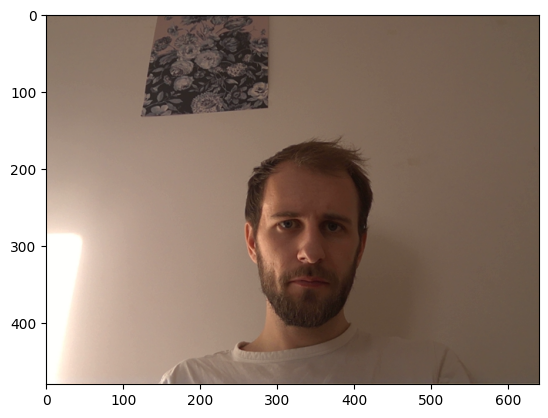

In [2]:
# Second cell - capture image
cap = cv2.VideoCapture(0)
cv2.waitKey(2000)
ret, frame = cap.read()
cap.release()
cv2.destroyAllWindows()

frame_rgb = None

if ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.show()
else:
    print("Failed to capture image")

c:\dev\uni\awt-pj-ws2425-3d-realtime-reconstruction\vendor\Depth-Anything-V2


xFormers not available
xFormers not available


(1600, 1200)


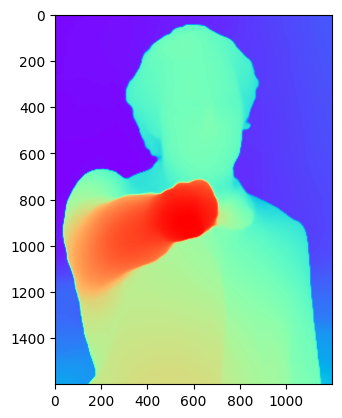

In [3]:
import sys
sys.path.append('../')
from pipeline.components.pc_generator.DepthEstimator import DepthEstimator

temp_img = cv2.imread("../assets/mc.jpg")
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

depth_estimator = DepthEstimator()
depth = depth_estimator.predict(temp_img) #frame_rgb)
print(depth.shape)
plt.imshow(depth, cmap='rainbow')

## performance evaluation

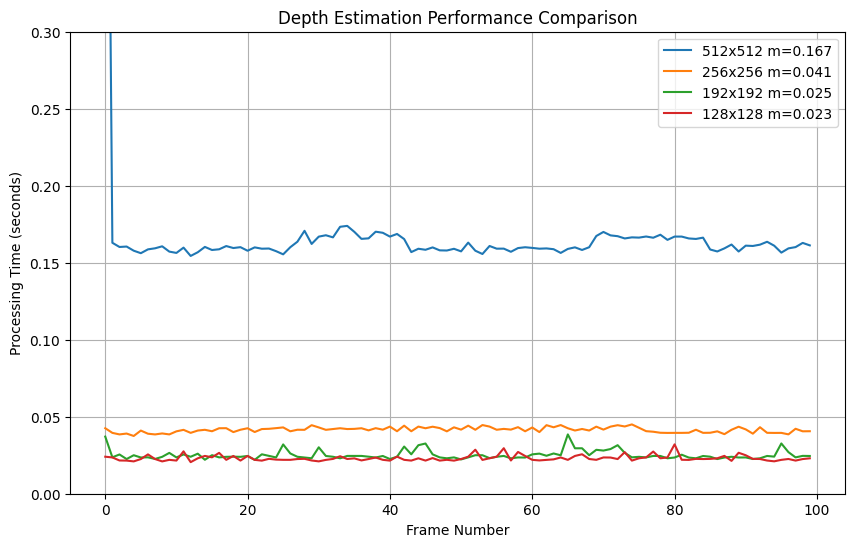

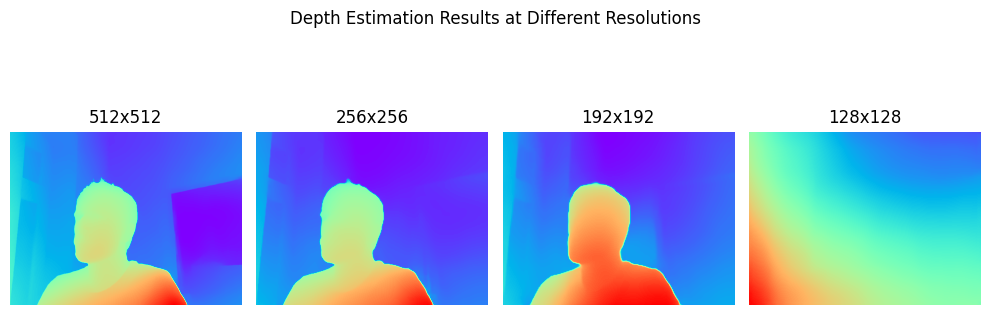

In [21]:
import time
import numpy as np

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise Exception("Could not open webcam")


def run_depth_estimation(input_size, frames = 100):
  times = []
  example_image = None
  depth_estimator = DepthEstimator(input_size=input_size)
  for i in range(frames):
    start_time = time.time()

    ret, frame = cap.read()
    depth = depth_estimator.predict(frame_rgb)
    end_time = time.time()

    if i == frames/2:
      example_image = depth

    times.append(end_time - start_time)
                    
  cap.release()
  cv2.destroyAllWindows()

  return times, example_image

times_a, image_a = run_depth_estimation(input_size=518)
times_b, image_b = run_depth_estimation(input_size=256)
times_c, image_c = run_depth_estimation(input_size=192)
times_d, image_d = run_depth_estimation(input_size=128)

# Plot performance comparison
plt.figure(figsize=(10,6))
plt.plot(times_a, label=f'512x512 m={np.mean(times_a):.3f}')
plt.plot(times_b, label=f'256x256 m={np.mean(times_b):.3f}')
plt.plot(times_c, label=f'192x192 m={np.mean(times_c):.3f}')
plt.plot(times_d, label=f'128x128 m={np.mean(times_d):.3f}')
plt.ylim(0, 0.3)
plt.xlabel('Frame Number')
plt.ylabel('Processing Time (seconds)')
plt.title('Depth Estimation Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot depth images
fig, axes = plt.subplots(1, 4, figsize=(10,4))
fig.suptitle('Depth Estimation Results at Different Resolutions')
axes[0].imshow(image_a, cmap='rainbow')
axes[0].set_title('512x512')
axes[0].axis('off')
axes[1].imshow(image_b, cmap='rainbow') 
axes[1].set_title('256x256')
axes[1].axis('off')
axes[2].imshow(image_c, cmap='rainbow')
axes[2].set_title('192x192') 
axes[2].axis('off')
axes[3].imshow(image_d, cmap='rainbow')
axes[3].set_title('128x128') 
axes[3].axis('off')

plt.tight_layout()
plt.show()


## Point Cloud generation

In [ ]:
import open3d as o3d
import numpy as np

def create_point_cloud(image_rgb, image_depth):
    width = np.shape(image_depth)[1]
    height = np.shape(image_depth)[0]

    # Convert depth to 3D points without perspective scaling
    depth = np.asarray(image_depth)

    print(depth)

    # Generate a 3D point grid
    u, v = np.meshgrid(np.arange(width), np.arange(height))

    # Convert to 3D coordinates
    x = u 
    y = v
    z = depth * 1000 # Maintain straight-line scaling without perspective adjustment

    # Stack and filter valid points
    points = np.dstack((x, y, z)).reshape(-1, 3)
    valid_points = points[depth.reshape(-1) > 0]  # Remove zero-depth points

    print(valid_points)

    # Create an Open3D point cloud from the resulting 3D points
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(valid_points)

    # Set the colors from the RGB image
    rgb = np.asarray(image_rgb).reshape(-1, 3) / 255.0  # Normalize to [0, 1]
    pcd.colors = o3d.utility.Vector3dVector(rgb[depth.reshape(-1) > 0])

    # Flip the point cloud (optional, depending on the coordinate system)
    #pcd.transform([[-1, 0, 0, 0],
    #            [0, -1, 0, 0],
    #            [0, 0, 1, 0],
    #            [0, 0, 0, 1]])

    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])

In [18]:
depth = depth_estimator.predict(temp_img)

print(np.shape(depth))
print(np.shape(temp_img))

create_point_cloud(temp_img, depth)

(1600, 1200)
(1600, 1200, 3)
[[0.01365988 0.01333925 0.01301862 ... 0.10572845 0.10218745 0.09864692]
 [0.01360511 0.01337527 0.01314543 ... 0.10702951 0.10410069 0.10117226]
 [0.01355034 0.01341129 0.01327225 ... 0.10833056 0.10601391 0.10369759]
 ...
 [0.21667628 0.2187287  0.2207811  ... 0.25019214 0.24440569 0.23862004]
 [0.21584207 0.21795754 0.22007297 ... 0.25018507 0.24443357 0.23868284]
 [0.21500787 0.21718636 0.21936484 ... 0.25017804 0.24446143 0.23874563]]
[[0.00000000e+00 0.00000000e+00 1.36598845e+01]
 [1.00000000e+00 0.00000000e+00 1.33392515e+01]
 [2.00000000e+00 0.00000000e+00 1.30186176e+01]
 ...
 [1.19700000e+03 1.59900000e+03 2.50178040e+02]
 [1.19800000e+03 1.59900000e+03 2.44461426e+02]
 [1.19900000e+03 1.59900000e+03 2.38745636e+02]]
